In [3]:
#import necessary packages
import pandas as pd
import json
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

In [7]:
def request_worldometer_table():
    """
    Function to send request to get worldometer coronavirus table page
    """
    url = 'https://www.worldometers.info/coronavirus/'
    try:
        response = requests.get(url)
    except requests.exceptions.ConnectionError as e:
        print('Error Connecting:', e.args)
        return None
    except requests.exceptions.RequestException as e:
        print('Error Connecting:', e.args)
        return None
    else:
        soup = BeautifulSoup(response.text, 'lxml')
        table = soup.find_all('table')
        
        dataframe = pd.read_html(str(table))[0]
        columns = ['Position', 'Country', 'Total Cases', 'Drop1', 'Total Deaths', 'Drop2', 'Total Recovered', 'Active Cases', 'Serious / Critical Cases', 'Drop3', 'Drop4', 'Total Tests', 'Drop5', 'population']
        dataframe.columns = columns
        dataframe.drop(['Position', 'Drop1', 'Drop2', 'Drop3', 'Drop4', 'Drop5'], axis=1, inplace=True)
        dataframe.drop([0, len(dataframe.index) -1 ], inplace=True)#Remove the first and last rows from the table because they're not countries
        return json.loads(dataframe.to_json(orient="records"))

In [9]:
worldometer_json = request_worldometer_table()

In [10]:
def get_detailed_table():
    table = worldometer_json
    corona_virus_detailed_table = pd.DataFrame(table)
    corona_virus_detailed_table.sort_values(by='Total Cases', ascending=False, inplace=True)
    corona_virus_detailed_table.index = range(1, len(corona_virus_detailed_table) + 1)
    return corona_virus_detailed_table

get_detailed_table().head()

,Country,Total Cases,Total Deaths,Total Recovered,Active Cases,Serious / Critical Cases,Total Tests,population
1,USA,1593039,94941.0,370812.0,1127286.0,17815.0,14173807.0,330785250.0
2,Russia,308705,2972.0,85392.0,220341.0,2300.0,7578029.0,145927633.0
3,Brazil,293357,18894.0,116683.0,157780.0,8318.0,735224.0,212389176.0
4,Spain,279524,27888.0,196958.0,54678.0,1152.0,3037840.0,46752802.0
5,UK,248293,35704.0,NaN,NaN,1559.0,2962227.0,67846185.0


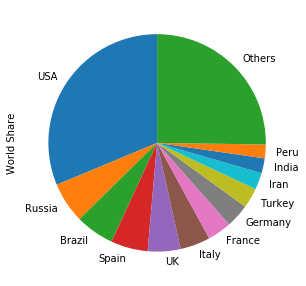

In [13]:
def get_share():
    columns = ['Country', 'Total Cases']
    corona_virus_detailed_table = get_detailed_table()
    countries_world_share = pd.DataFrame(corona_virus_detailed_table, columns = columns)
    countries_world_share['World Share'] = countries_world_share['Total Cases'] / sum(countries_world_share['Total Cases']) * 100
    more_than_2 = countries_world_share[countries_world_share['World Share'] >= 2]
    less_than_2 = countries_world_share[countries_world_share['World Share'] < 2]
    others = pd.DataFrame({'Country' : 'Others', 'Total Cases' : less_than_2['Total Cases'].sum(), 
                           'World Share': less_than_2['World Share'].sum()}, index=[len(more_than_2) + 1])

    world_share_aggregate = pd.concat([more_than_2, others], axis=0)
    return world_share_aggregate.set_index('Country')

get_share().plot.pie(y='World Share', figsize=(5,5), startangle=90, legend=False)

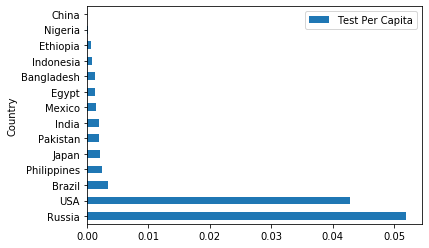

In [20]:
def get_tests_per_capita_table(start=0, stop=15, population_floor=0):
    corona_virus_detailed_table = get_detailed_table()
    tests_per_capita_table = pd.DataFrame(corona_virus_detailed_table, columns=['Country','Total Tests', 'population'])
    tests_per_capita_table['Test Per Capita'] = tests_per_capita_table['Total Tests']/tests_per_capita_table['population']
    tests_per_capita_table.sort_values(by='Test Per Capita', ascending=False, inplace=True)
    tests_per_capita_table.index = range(1, len(tests_per_capita_table) + 1)
    if population_floor == 0:
        return tests_per_capita_table[start : stop]
    elif population_floor == 10000000:
        tpct_over_ten_million = tests_per_capita_table[tests_per_capita_table['population'] >= 10000000]
        tpct_over_ten_million.index = range(1, len(tpct_over_ten_million) + 1)
        return tpct_over_ten_million[start : stop]
    elif population_floor == 100000000:
        tpct_over_hundred_million = tests_per_capita_table[tests_per_capita_table['population'] >= 100000000]
        tpct_over_hundred_million.index = range(1, len(tpct_over_hundred_million) + 1)
        return tpct_over_hundred_million[start : stop]

get_tests_per_capita_table(population_floor=100000000).plot.barh(x='Country', y='Test Per Capita')

In [28]:
def get_death_rate(start=0, stop=10):
    corona_virus_detailed_table = get_detailed_table()
    death_rate = pd.DataFrame(corona_virus_detailed_table, columns=['Country', 'Total Cases', 'Total Deaths'])
    death_rate['Death Rate'] = (death_rate['Total Deaths'] / death_rate['Total Cases']) * 100
    death_rate.sort_values(by='Death Rate', ascending=False, inplace=True)
    death_rate = death_rate[death_rate['Total Cases'] >= 1000]
    death_rate.index = range(1, len(death_rate) + 1)
    return death_rate[start:stop]

get_death_rate()

,Country,Total Cases,Total Deaths,Death Rate
1,Belgium,55983,9150.0,16.344247
2,France,181575,28132.0,15.493322
3,UK,248293,35704.0,14.379785
4,Italy,227364,32330.0,14.219489
5,Hungary,3641,473.0,12.990937
6,Netherlands,44447,5748.0,12.932256
7,Sweden,31523,3831.0,12.153031
8,Mexico,56594,6090.0,10.760858
9,Spain,279524,27888.0,9.976961
10,Ecuador,34854,2888.0,8.285993


In [33]:
def get_recovered(start=0, stop=10):
    corona_virus_detailed_table = get_detailed_table()
    percentage_recovered = pd.DataFrame(corona_virus_detailed_table, columns=['Country', 'Total Cases', 'Total Recovered'])
    percentage_recovered['Percentage Recovered'] = (percentage_recovered['Total Recovered']/percentage_recovered['Total Cases']) * 100
    percentage_recovered.sort_values(by='Percentage Recovered', ascending=False, inplace=True)
    percentage_recovered.index = range(1, len(percentage_recovered) + 1)
    return percentage_recovered[start:stop]

get_recovered()

,Country,Total Cases,Total Recovered,Percentage Recovered
1,Saint Pierre Miquelon,1,1.0,100.0
2,Seychelles,11,11.0,100.0
3,Faeroe Islands,187,187.0,100.0
4,French Polynesia,60,60.0,100.0
5,Macao,45,45.0,100.0
6,Eritrea,39,39.0,100.0
7,Timor-Leste,24,24.0,100.0
8,Saint Lucia,18,18.0,100.0
9,New Caledonia,18,18.0,100.0
10,Dominica,16,16.0,100.0


In [47]:
def get_active_critical_table(start=0, stop=10):
    corona_virus_detailed_table = get_detailed_table()
    active_table = pd.DataFrame(corona_virus_detailed_table, columns=['Country', 'Total Cases', 'Active Cases', 'Serious / Critical Cases'])
    active_table['% Active(of Total Cases)'] = (active_table['Active Cases']/active_table['Total Cases']) * 100
    active_table['% Critical(of active)'] = (active_table['Serious / Critical Cases']/active_table['Active Cases']) * 100
    active_table.dropna(inplace=True)
    active_table.index = range(1, len(active_table) + 1)
#     active_table = active_table[active_table['Country'] == 'Nigeria']
    return active_table[start:stop]
    
get_active_critical_table()

,Country,Total Cases,Active Cases,Serious / Critical Cases,% Active(of Total Cases),% Critical(of active)
1,USA,1593039,1127286.0,17815.0,70.763239,1.580344
2,Russia,308705,220341.0,2300.0,71.375909,1.043837
3,Brazil,293357,157780.0,8318.0,53.784297,5.271898
4,Spain,279524,54678.0,1152.0,19.561111,2.106880
5,Italy,227364,62752.0,676.0,27.599796,1.077257
6,France,181575,90089.0,1794.0,49.615310,1.991364
7,Germany,178531,12261.0,1045.0,6.867715,8.522959
8,Turkey,152587,34378.0,877.0,22.530098,2.551050
9,Iran,126949,20958.0,2735.0,16.508992,13.049909
10,Peru,104020,59028.0,869.0,56.746779,1.472183


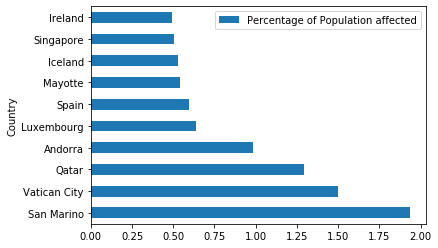

In [48]:
def get_percentage_affected(start=0, stop=10):
    corona_virus_detailed_table = get_detailed_table()
    country_percentage_affected = pd.DataFrame(corona_virus_detailed_table, columns=['Country', 'Total Cases', 'population'])
    country_percentage_affected['Percentage of Population affected'] = (country_percentage_affected['Total Cases'] / country_percentage_affected['population'])*100
    country_percentage_affected.sort_values(by='Percentage of Population affected', ascending=False, inplace=True)
    country_percentage_affected.index = range(1, len(country_percentage_affected) + 1)
    return country_percentage_affected[start:stop]

get_percentage_affected().plot.barh(x='Country', y='Percentage of Population affected')

In [51]:
#trying to write tests for the functions
import unittest

class TestNotebook(unittest.TestCase):
    
    def test_get_countries_data_list(self):
        self.assertIsInstance(request_worldometer_table(), list)
    
    def test_get_countries_data_contains_dict(self):
        self.assertIsInstance(request_worldometer_table()[0], dict)
        
unittest.main(argv=[''], verbosity=2, exit=False)

test_get_countries_data_contains_dict (__main__.TestNotebook) ... ok
test_get_countries_data_list (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 2 tests in 11.010s

OK
